In [68]:
# import packages
import csv
import pandas as pd
import PyPDF2
import requests
import time
import os
import random
from requests.auth import HTTPProxyAuth
from bs4 import BeautifulSoup
import numpy as np
from selenium import webdriver
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.firefox.service import Service
from selenium.common.exceptions import TimeoutException, WebDriverException, NoSuchElementException
import os
import re
from lxml import etree
from nltk import ngrams
import json
import shutil

In [69]:
# import internal modules
import file_path_management as fpath
import public_library as plib
import extract_info
import parameters as params
import download_and_process_pdf as dpp
import dataframe_columns as df_col

In [70]:
# scan the rows in the test 1000 csv file and print the full_text_url and pdf_url of the papers that have no pdf_url
input_path = fpath.poten_litera_testing_set_1000_text_extract_and_count
df = pd.read_csv(input_path, header=0, sep=',')
columns = [
    "INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "PDF_URL", 
    "TITLE", "TEXT_TAK", "TEXT_500"
]
columns = columns + df_col.text_columns_to_add # add keyword group text
columns = columns + df_col.count_columns_to_add # add keyword group count
columns_to_add = ["TT?(Y/N/MB/NA)", "MACAQUE?(Y/N/MB/NA)", "TC_OR_CT?(Y/N/MB/NA)", "RELEVANT?(Y/N/MB/NA)", "READ_BY(A/D/R)", "COMMENT"] # add columns for documenting labels
columns = columns + columns_to_add
df.columns = columns

for ind in df.index:
    index = df.at[ind, "INDEX"]
    full_text_url = df.at[ind, "FULL_TEXT_URL"]
    pdf_url = df.at[ind, "PDF_URL"]
    relevant = df.at[ind, "RELEVANT?(Y/N/MB/NA)"]
    
    line_number_in_csv = ind + 2
    print("Line number:", line_number_in_csv, "INDEX:", index)
    print("ind: ", ind, )
    print("full_text_url: ", full_text_url)
    print("pdf_url: ", pdf_url)
    print("relevant: ", relevant)
    print("\n")

Line number: 2 INDEX: 8563
ind:  0
full_text_url:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4812498/
pdf_url:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4812498/pdf/SCI2016-9745315.pdf
relevant:  nan


Line number: 3 INDEX: 7378
ind:  1
full_text_url:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3103088/
pdf_url:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3103088/pdf/nihms278119.pdf
relevant:  nan


Line number: 4 INDEX: 9735
ind:  2
full_text_url:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1359021/
pdf_url:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1359021/pdf/11797318.pdf
relevant:  nan


Line number: 5 INDEX: 2259
ind:  3
full_text_url:  https://academic.oup.com/cercor/article/3/1/49/300105
pdf_url:  https://academic.oup.com/cercor/article-pdf/3/1/49/850918/3-1-49.pdf
relevant:  nan


Line number: 6 INDEX: 10784
ind:  4
full_text_url:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC496549/
pdf_url:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC496549/pdf/jnnpsyc00227

In [71]:
def get_areas_in_regions(region):
    Visual = ['V1', 'V2', 'V4', 'V6', 'MT', 'TEO']

    Temporal = ['TEpd', 'STPc', 'STPi', 'STPr']

    Parietal = ['LIP', '7A', '7B', '7m', 'DP']

    Somatosensory = ['1', '2', '3', '5', '24c']

    Auditory = ['ProM', 'OPRO']  # Note: The macaque auditory cortex has many subdivisions; this is a simplified representation.

    Motor = ['F1', 'F2', 'F3', 'F4', 'F5']

    Prefrontal = ['8B', '8l', '8m', '9', '9-46d', '9-46v', '46d', '32', '45A']

    Frontal = ['F7', '10']

    Orbitofrontal = ['13', '14']  # Note: The orbitofrontal cortex also has various subdivisions; this is a simplified representation.

    if region == 'Visual':
        return Visual
    elif region == 'Temporal':
        return Temporal
    elif region == 'Parietal':
        return Parietal
    elif region == 'Somatosensory':
        return Somatosensory
    elif region == 'Auditory':
        return Auditory
    elif region == 'Motor':
        return Motor
    elif region == 'Prefrontal':
        return Prefrontal
    elif region == 'Frontal':
        return Frontal
    elif region == 'Orbitofrontal':
        return Orbitofrontal
    else:
        return None

In [72]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

A = pd.read_csv('./datasets/macaque_corticoCortical_adjacency.csv', index_col=0)

# Create non-directed graph
G = nx.convert_matrix.from_pandas_adjacency(A, create_using=nx.Graph)

# print(G.nodes)

# pos = nx.spring_layout(G, seed=24)
# nx.draw_networkx(G, pos, with_labels=False, node_size=0, edge_cmap='Greys', width=0.1, alpha=0.5)

# # ALl this just to make the nodes certain colors
# macaque_regions = ['Visual', 'Temporal', 'Parietal', 'Somatosensory', 'Auditory',
#                    'Motor', 'Prefrontal', 'Frontal', 'Orbitofrontal']
# colors = ['#4c6ef5', '#228be6', '#15aabf', '#12b886', '#40c057', '#82c91e', '#fab005', '#fd7e14']
# for region, c in zip(macaque_regions, colors):
#     # subset = subset = macaque.get_areas_in_regions(region)
#     subset = get_areas_in_regions(region)
#     nodes = []
#     for node in subset:
#         if node in G.nodes:
#             nodes.append(node)
#     nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=c, node_size=30, alpha=0.8, label=region)

# # Create labels on top
# nx.draw_networkx(G, pos, with_labels=True, node_size=0, width=0, alpha=1, font_size=7)

# plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig('Cortico_cortical_connectivity_macaque.png', dpi=300, bbox_inches='tight')

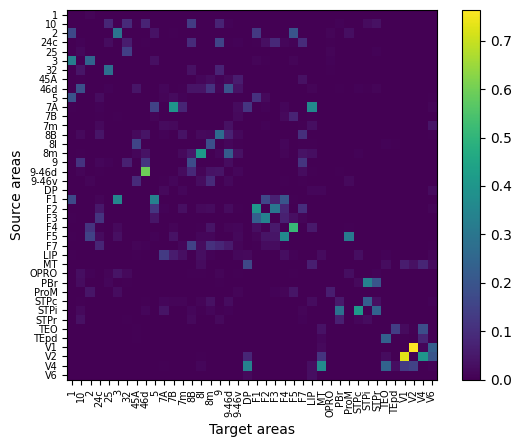

In [73]:
# To show the adjacency matrix
plt.imshow(A)
plt.yticks(range(len(A.columns)), A.columns, fontsize=7)
plt.ylabel('Source areas', fontsize=10)
plt.xticks(range(len(A.columns)), A.columns, rotation=90, fontsize=7)
plt.xlabel('Target areas', fontsize=10)
plt.colorbar()

# plt.subplots_adjust(bottom=0.1)
plt.savefig('Cortico_cortical_connectivity_heatmap_macaque.png', dpi=300, bbox_inches='tight')

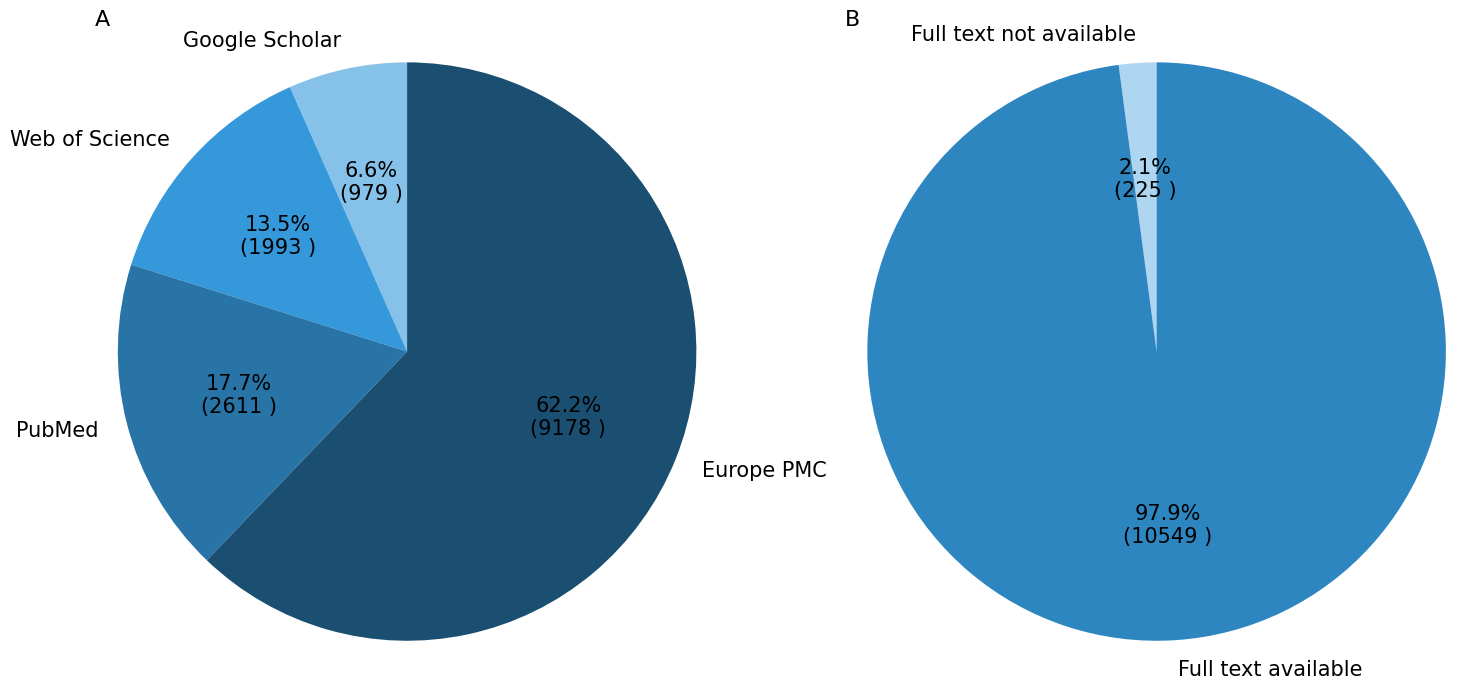

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels1 = ['Google Scholar', 'Web of Science', 'PubMed', 'Europe PMC']
sizes1 = [980, 1993, 2612, 9178]
labels2 = ['Full text not available', 'Full text available']
sizes2 = [226, 10550]

# Custom function to format the label
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.1f}%\n({:d} )".format(pct, absolute)

# Cold color palette
colors1 = ['#85C1E9', '#3498DB', '#2874A6', '#1B4F72']
colors2 = ['#AED6F1', '#2E86C1']

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

# Font sizes
title_fontsize = 16
label_fontsize = 15
autopct_fontsize = 10

# First pie chart
ax1.pie(sizes1, labels=labels1, autopct=lambda pct: func(pct, sizes1), 
        startangle=90, colors=colors1, textprops={'fontsize': label_fontsize})
ax1.set_title("A", loc='left', fontsize=title_fontsize)
ax1.axis('equal')

# Second pie chart
ax2.pie(sizes2, labels=labels2, autopct=lambda pct: func(pct, sizes2), 
        startangle=90, colors=colors2, textprops={'fontsize': label_fontsize})
ax2.set_title("B", loc='left', fontsize=title_fontsize)
ax2.axis('equal')

# Show both pie charts side by side
plt.tight_layout()  # Adjusts the space between the two plots for better visualization
plt.show()

# Save figure
fig.savefig('pie_chart.png', dpi=300, bbox_inches='tight')
